### Лабораторная работа №2

# Методы снижения размерности

Седунов Илья, <br>
Альперович Вадим, <br>
МАГ-ИАД21.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook

import warnings
warnings.simplefilter('ignore')
sns.set(style="darkgrid")

# 1. Data

Выполнить первичную обработку данных. Сделать первые выводы.

## 1.1 Data loading

|col 1 |col 2 |col 3 |col 4 |col 5 |col 6 |
| - | - | - | - | - | -|
| Возраст (лет)  | Количество иждивенцев     | Доход (руб./мес.)| Срок проживания в регионе (лет) | Оценка автомобиля заемщика (USD) | Размер кредита (тыс. руб.)|
| age  | dependents | income| residence | car_valuation | loan_amount |


In [2]:
%%time
columns = ['age', 'dependents', 'income', 'residence', 'car_valuation', 'loan_amount']
df = pd.read_excel('data/HW_2_v7.xls', 
                   header=None,
                   names=columns
                  )

Wall time: 56 ms


In [3]:
df.head()

,age,dependents,income,residence,car_valuation,loan_amount
0,54,3,16700,18,18000,177000
1,36,2,33800,6,34000,337000
2,37,1,12900,9,12000,126000
3,44,2,17700,13,18000,180000
4,54,4,20000,19,22000,211000


## 1.2 EDA

**Simple stats**

In [4]:
print(f'Rows count: {len(df)} Cols num: {df.shape[1]}')

Rows count: 50 Cols num: 6


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   age            50 non-null     int64
 1   dependents     50 non-null     int64
 2   income         50 non-null     int64
 3   residence      50 non-null     int64
 4   car_valuation  50 non-null     int64
 5   loan_amount    50 non-null     int64
dtypes: int64(6)
memory usage: 2.5 KB
None


In [6]:
np.around(df.describe(), 1)

,age,dependents,income,residence,car_valuation,loan_amount
count,50.0,50.0,50.0,50.0,50.0,50.0
mean,40.0,2.0,19992.0,10.0,20060.0,199960.0
std,8.0,1.0,10002.1,5.0,10096.3,100021.8
min,24.0,0.0,1500.0,0.0,0.0,4000.0
25%,35.0,1.2,12600.0,6.0,13000.0,126500.0
50%,40.0,2.0,17900.0,10.0,18500.0,183000.0
75%,46.0,2.8,29075.0,14.0,29750.0,293000.0
max,56.0,4.0,43300.0,19.0,44000.0,437000.0


**Charts & dists**

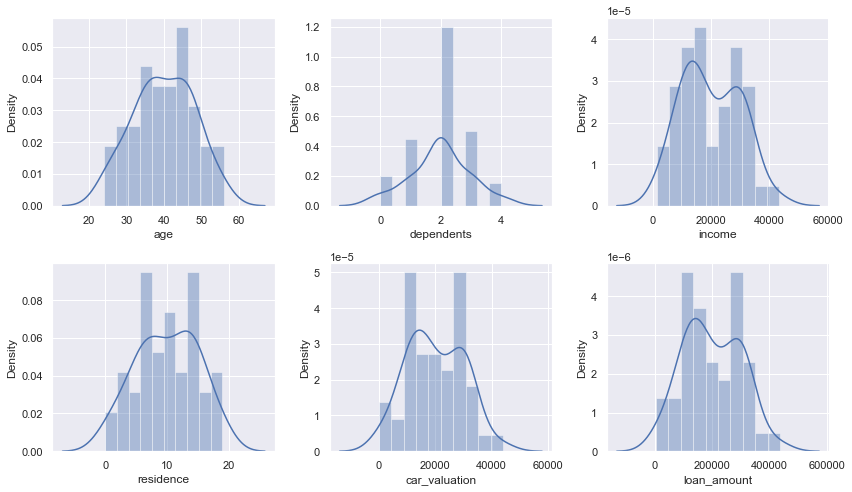

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3) 
axes = axes.flatten()        
fig.set_size_inches(12, 7)

for ax, col in zip(axes, df.columns):
    sns.distplot(df[col], ax = ax, bins=10)
fig.tight_layout()

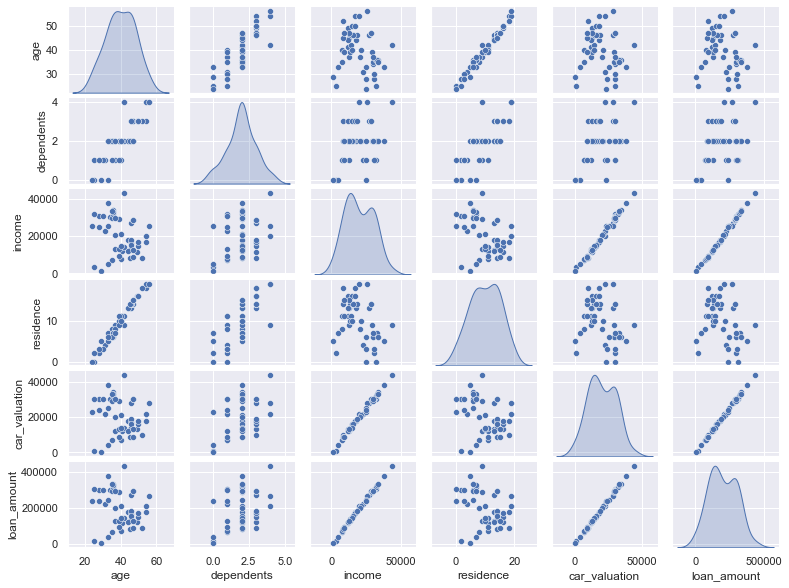

In [8]:
g = sns.pairplot(data=df, diag_kind="kde")
g.fig.set_figwidth(11)
g.fig.set_figheight(8)
pass

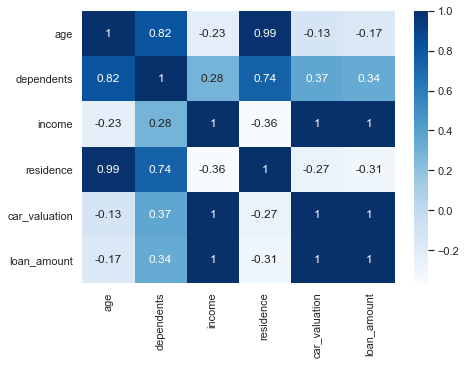

In [9]:
corr = df.corr(method='pearson')
plt.figure(figsize=(7, 5))
sns.heatmap(corr, cmap="Blues", annot=True)
pass

# 2. Dimensionality reduction via PCA

- Выполнить центрирование данных и такую нормировку, что евклидова норма каждого признака
равна 1 (полученная матрица обозначается через Z).
- Найти SVD разложение матрицы Z (матрицы U, S, V). Докажите, что при выбранной
нормировке, коэффициенты разложения столбцов матрицы Z по скрытым факторам являются
корреляциями этих столбцов и скрытых факторов.
- Исследуйте, сколько скрытых факторов (главные факторы) достаточно для хорошей
аппроксимации матрицы данных Z. Заменить значения исходных признаков линейными
комбинациями главных факторов (матрица Z k , k – число главных факторов). Оценить
погрешность аппроксимации в евклидовой матричной норме и норме Фробениуса.
- Сравнить матрицы корреляций признаков для матрицы Z и матрицы Z k . Оценить качество
аппроксимации по близости матриц корреляций (можно использовать относительную
погрешность в одной из матричных норм)
- Используя выделенные главные факторы, найти представления клиентов векторами меньшей
размерности (размерности k).
- Используя представление клиентов векторами меньшей размерности, построить карту
клиентов. Сделать выводы о клиентах банка.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html#sklearn.preprocessing.normalize
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [10]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, TruncatedSVD

**Data normalization**

*Выполнить центрирование данных и такую нормировку, что евклидова норма каждого признака равна 1*

In [11]:
Z = normalize(df, norm='l2', axis=0) 
df_normalized = pd.DataFrame(Z, columns=df.columns)
df_normalized.head()

,age,dependents,income,residence,car_valuation,loan_amount
0,0.187243,0.19245,0.105862,0.22752,0.113581,0.112182
1,0.124829,0.12830,0.214259,0.07584,0.214542,0.213590
2,0.128296,0.06415,0.081773,0.11376,0.075721,0.079859
3,0.152568,0.12830,0.112201,0.16432,0.113581,0.114084
4,0.187243,0.25660,0.126780,0.24016,0.138821,0.133732


In [12]:
# np.around(df_normalized.describe(), 1)

In [13]:
for col in df_normalized.columns:
    print(col, f'l2-norm: {round(np.linalg.norm(df_normalized[col], ord=2), 1)}')

age l2-norm: 1.0
dependents l2-norm: 1.0
income l2-norm: 1.0
residence l2-norm: 1.0
car_valuation l2-norm: 1.0
loan_amount l2-norm: 1.0


**SVD**

- *Найти SVD разложение матрицы Z (матрицы U, S, V).*
- *Докажите, что при выбранной нормировке, коэффициенты разложения столбцов матрицы Z по скрытым факторам являются корреляциями этих столбцов и скрытых факторов.*

In [14]:
from scipy.linalg import svd 

U, S, VT = np.linalg.svd(df_normalized,  full_matrices=False,  compute_uv=True)

In [15]:
from math import isclose

for i in range(Z.shape[1]):
    for j in range(U.shape[1]):
        corr_Zi_Uj = np.correlate(Z[:, i], U[:, j])[0]
        svd_coef = VT[j, i] * S[j]
        print(f'Feature Z_{i} and Component U_{j}')
        if isclose(corr_Zi_Uj, svd_coef):
            print(f'\tEqual: {corr_Zi_Uj:.2f} == {svd_coef:.2f}')
        else:
            print('\tNot equal')

Feature Z_0 and Component U_0
	Equal: -0.96 == -0.96
Feature Z_0 and Component U_1
	Equal: -0.22 == -0.22
Feature Z_0 and Component U_2
	Equal: 0.14 == 0.14
Feature Z_0 and Component U_3
	Equal: -0.04 == -0.04
Feature Z_0 and Component U_4
	Equal: -0.00 == -0.00
Feature Z_0 and Component U_5
	Equal: 0.00 == 0.00
Feature Z_1 and Component U_0
	Equal: -0.96 == -0.96
Feature Z_1 and Component U_1
	Equal: -0.20 == -0.20
Feature Z_1 and Component U_2
	Equal: -0.17 == -0.17
Feature Z_1 and Component U_3
	Equal: -0.03 == -0.03
Feature Z_1 and Component U_4
	Equal: 0.00 == 0.00
Feature Z_1 and Component U_5
	Equal: -0.00 == -0.00
Feature Z_2 and Component U_0
	Equal: -0.96 == -0.96
Feature Z_2 and Component U_1
	Equal: 0.29 == 0.29
Feature Z_2 and Component U_2
	Equal: 0.02 == 0.02
Feature Z_2 and Component U_3
	Equal: -0.00 == -0.00
Feature Z_2 and Component U_4
	Equal: 0.00 == 0.00
Feature Z_2 and Component U_5
	Equal: -0.00 == -0.00
Feature Z_3 and Component U_0
	Equal: -0.90 == -0.90
Featu

- *Исследуйте, сколько скрытых факторов (главные факторы) достаточно для хорошей аппроксимации матрицы данных Z. Заменить значения исходных признаков линейными комбинациями главных факторов (матрица Z k , k – число главных факторов).*
- *Оценить погрешность аппроксимации в евклидовой матричной норме и норме Фробениуса.*

In [16]:
print(f'Singular values: {np.around(S, 2)}')
sqr_singular_values = S ** 2
print(f'Sqr singular values: {np.around(sqr_singular_values, 2)}')
total_variance = np.sum(sqr_singular_values)
print(f'Total variance: {total_variance:.2f}')
explained_variances = S ** 2 / total_variance
print(f'Explained variances: {np.around(explained_variances, 2)}')

Singular values: [2.33 0.72 0.22 0.07 0.01 0.  ]
Sqr singular values: [5.43 0.52 0.05 0.   0.   0.  ]
Total variance: 6.00
Explained variances: [0.91 0.09 0.01 0.   0.   0.  ]


In [17]:
explained_var_2comp = np.sum(explained_variances[:2])
print(f'Explained variance (via 2 components): {explained_var_2comp * 100:.1f}%')

Explained variance (via 2 components): 99.1%


In [18]:
K = 2
Z_K = U.dot(np.diag(S)[:,:K].dot(VT[:K, :]))
print('Original Z matrix:')
print(np.around(Z[:5], 2))

print('\nApproximated Z matrix by 2 components:')
print(np.around(Z_K[:5], 2))

Original Z matrix:
[[0.19 0.19 0.11 0.23 0.11 0.11]
 [0.12 0.13 0.21 0.08 0.21 0.21]
 [0.13 0.06 0.08 0.11 0.08 0.08]
 [0.15 0.13 0.11 0.16 0.11 0.11]
 [0.19 0.26 0.13 0.24 0.14 0.13]]

Approximated Z matrix by 2 components:
[[0.2  0.19 0.11 0.22 0.11 0.11]
 [0.12 0.13 0.22 0.08 0.21 0.21]
 [0.1  0.1  0.08 0.11 0.08 0.08]
 [0.15 0.15 0.11 0.15 0.11 0.11]
 [0.22 0.22 0.13 0.24 0.14 0.13]]


In [19]:
Z_errors = Z - Z_K
enorm_F = np.linalg.norm(Z_errors, ord='fro') ** 2
enorm_2 = np.linalg.norm(Z_errors, ord=2)

print(f'Approx error in Fro norm: {enorm_F:.3f} (sigma{K+1}^2+...sigmaN^2={np.sum(S[2:]**2):.3f})')
print(f'Approx error in Euclidian norm: {enorm_2:.3f} (sigma{K+1}={S[K]:.3f})')

Approx error in Fro norm: 0.054 (sigma3^2+...sigmaN^2=0.054)
Approx error in Euclidian norm: 0.223 (sigma3=0.223)


In [20]:
relative_enorm_F = enorm_F /  np.linalg.norm(Z, ord='fro') ** 2
print(f'Approx relative error in Frob norm: {(1 - explained_var_2comp) * 100:.3f}%')
print(f'Approx relative error in Frob norm: {(relative_enorm_F):.3f}%')

Approx relative error in Frob norm: 0.907%
Approx relative error in Frob norm: 0.009%


*Сравнить матрицы корреляций признаков для матрицы Z и матрицы Z k . Оценить качество аппроксимации по близости матриц корреляций*

In [21]:
df_approx_K = pd.DataFrame(Z_K, columns=df.columns)

In [22]:
Z_corr = df_normalized.corr()
np.around(df_normalized.corr(), 3)

,age,dependents,income,residence,car_valuation,loan_amount
age,1.000,0.819,-0.225,0.987,-0.132,-0.168
dependents,0.819,1.000,0.285,0.738,0.372,0.338
income,-0.225,0.285,1.000,-0.363,0.995,0.998
residence,0.987,0.738,-0.363,1.000,-0.272,-0.307
car_valuation,-0.132,0.372,0.995,-0.272,1.000,0.999
loan_amount,-0.168,0.338,0.998,-0.307,0.999,1.000


In [23]:
Z_K_corr = df_approx_K.corr()
np.around(df_approx_K.corr(), 3)

,age,dependents,income,residence,car_valuation,loan_amount
age,1.000,0.997,0.132,0.891,0.166,0.154
dependents,0.997,1.000,0.206,0.854,0.239,0.227
income,0.132,0.206,1.000,-0.333,0.999,1.000
residence,0.891,0.854,-0.333,1.000,-0.301,-0.312
car_valuation,0.166,0.239,0.999,-0.301,1.000,1.000
loan_amount,0.154,0.227,1.000,-0.312,1.000,1.000


In [24]:
corr_errors = Z_corr - Z_K_corr
ecorr_norm_F = np.linalg.norm(corr_errors, ord='fro') ** 2
ecorr_norm_2 = np.linalg.norm(corr_errors, ord=2)

print(f'Approx error in Fro norm: {ecorr_norm_F:.3f}')
print(f'Approx error in Euclidian norm: {ecorr_norm_2:.3f}')

Approx error in Fro norm: 0.826
Approx error in Euclidian norm: 0.679


**Visualization**

- *Используя выделенные главные факторы, найти представления клиентов векторами меньшей размерности (размерности k).*
- *Используя представление клиентов векторами меньшей размерности, построить карту клиентов. Сделать выводы о клиентах банка.*

In [25]:
comp_K = U[:, :K]
comp_K[:5]

array([[-0.16365566, -0.17058968],
       [-0.17106441,  0.17860289],
       [-0.09492935, -0.04908803],
       [-0.13711726, -0.07227935],
       [-0.18911208, -0.16968201]])

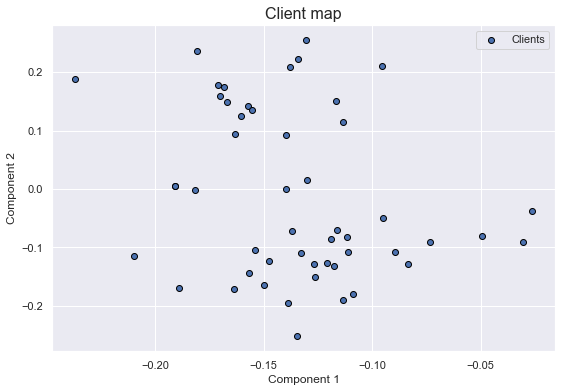

In [26]:
plt.figure(figsize=(9, 6))
plt.scatter(comp_K[:, 0], comp_K[:, 1], label='Clients', edgecolors='black')
plt.legend()
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title('Client map', fontsize=16)
plt.show()

# 3. Latent factors analysis

- Выписать матрицу коэффициентов разложения признаков z j по главным факторам. Исследовать
структуру этой матрицы с целью выделения групп признаков тесно связанных с каждым из
главных факторов.
- На основе анализа структуры матрицы коэффициентов разложения, предложить интерпретацию
выделенным главным факторам.
- Дать интерпретацию построенной выше карте клиентов.
- Выполнить вращения в пространстве главных факторов с целью улучшения структуры матрицы
коэффициентов разложения признаков z j по главным факторам. В случае улучшения структуры,
найти новое представление клиентов векторами меньшей размерности (размерности k).
Построить улучшенную карту клиентов и дать ее интерпретацию.

*Выписать матрицу коэффициентов разложения признаков z j по главным факторам.*

In [27]:
K = 2
loading_matrix = VT.T[:, :2].dot(np.diag(S[:K]))
print('Loading matrix:\n')
for i, feature in enumerate(df_normalized.columns):
    pad = 14 - len(feature)
    print(f'(z{i+1}) {feature}' + ' '*pad + \
          f'= {loading_matrix[i, 0]:.2f}*u1 + {loading_matrix[i, 1]:.2f}*u2')

Loading matrix:

(z1) age           = -0.96*u1 + -0.22*u2
(z2) dependents    = -0.96*u1 + -0.20*u2
(z3) income        = -0.96*u1 + 0.29*u2
(z4) residence     = -0.90*u1 + -0.44*u2
(z5) car_valuation = -0.96*u1 + 0.27*u2
(z6) loan_amount   = -0.96*u1 + 0.28*u2


**Комментарий:** 

Исходя из значений данной матрицы, сложно предложить интерпретации выделенным факторам, так как не образуются группы по коэффициентам (вклад первой компоненты в каждый из признаков больше, чем второй компоненты).

*Требуется улучшение матрицы коэффициентов.*

*Дать интерпретацию построенной выше карте клиентов.*

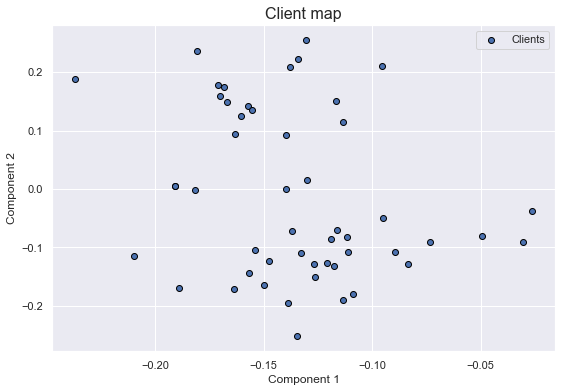

In [28]:
plt.figure(figsize=(9, 6))
plt.scatter(comp_K[:, 0], comp_K[:, 1], label='Clients', edgecolors='black')
plt.legend()
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title('Client map', fontsize=16)
plt.show()

**Комментарий:** 

Можно предположить, что в сторону увеличения значений ```Component1``` уменьшаются значения всех признаков,  а по увеличению ```Component2``` увеличивается ```income```, ```car_valuation``` и ```loan_amount```  (признаки, связанные с платежеспособнотью клиента) и уменьшаются ```age```, ```dependents``` и ```residense``` (признаки, связанные с социо-демографическими характеристиками или оседлостью клиента).

*Выполнить вращения в пространстве главных факторов с целью улучшения структуры матрицы коэффициентов разложения признаков z j по главным факторам. В случае улучшения структуры, найти новое представление клиентов векторами меньшей размерности (размерности k). Построить улучшенную карту клиентов и дать ее интерпретацию.*

Для выполнения данного пункта воспользуемся библиотекой https://github.com/EducationalTestingService/factor_analyzer, которая имеет функционал по вращению матрицы нагрузок.

In [29]:
# !pip install factor_analyzer
from factor_analyzer import Rotator
from factor_analyzer.rotator import ORTHOGONAL_ROTATIONS 

In [30]:
rotations = ['varimax', 'quartimax', 'equamax'] 
rotated_loadings = {}
for rotation_method in rotations:
    rotator = Rotator(method=rotation_method, max_iter=100)
    rotated = rotator.fit_transform(loading_matrix)
    rotated_loadings[rotation_method] = np.around(rotated, 5)
    print(f"method: {rotation_method}")
    print(np.around(rotated_loadings[rotation_method], 2), '\n')


method: varimax
[[-0.55 -0.82]
 [-0.57 -0.81]
 [-0.9  -0.44]
 [-0.35 -0.93]
 [-0.88 -0.47]
 [-0.89 -0.46]] 

method: quartimax
[[-0.96 -0.26]
 [-0.96 -0.23]
 [-0.97  0.26]
 [-0.88 -0.47]
 [-0.97  0.24]
 [-0.97  0.24]] 

method: equamax
[[-0.96 -0.26]
 [-0.96 -0.23]
 [-0.97  0.26]
 [-0.88 -0.47]
 [-0.97  0.24]
 [-0.97  0.24]] 



In [31]:
rotated_loading = rotated_loadings["varimax"]
# print(np.around(rotated_loading, 2))
for i, feature in enumerate(df_normalized.columns):
    pad = 14 - len(feature)
    print(f'{feature}' + ' '*pad + \
          f'= {rotated_loading[i, 0]:.2f}*u1 + {rotated_loading[i, 1]:.2f}*u2')

age           = -0.55*u1 + -0.82*u2
dependents    = -0.57*u1 + -0.81*u2
income        = -0.90*u1 + -0.44*u2
residence     = -0.35*u1 + -0.93*u2
car_valuation = -0.88*u1 + -0.47*u2
loan_amount   = -0.89*u1 + -0.46*u2


**Комментарий:** 

Получив наиболее подходящее вращение матрицы коэффициентов с помощью метода ```varimax```, можно заметить, что в новой матрице первой компоненте соответствуют признаки, связанные с платежеспособностью (```income```, ```car_valuation``` и ```loan_amount```), а второй компоненте признаки относящиеся к оседлости клиента (```age```, ```dependents``` и ```residense```)

In [32]:
rotated_loading

array([[-0.54753, -0.82421],
       [-0.56507, -0.80651],
       [-0.89588, -0.44373],
       [-0.35263, -0.93451],
       [-0.88479, -0.46561],
       [-0.88891, -0.45795]])

In [33]:
# ???
# comp_K_rotated = U.dot(rotated_loading)[:, :K] 
comp_K_rotated = df_normalized.to_numpy() @ rotated_loading

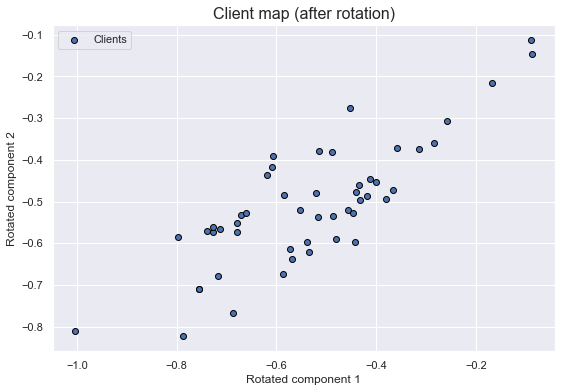

In [34]:
plt.figure(figsize=(9, 6))
plt.scatter(comp_K_rotated[:, 0], comp_K_rotated[:, 1], label='Clients', edgecolors='black')
plt.legend()
plt.ylabel('Rotated component 2')
plt.xlabel('Rotated component 1')
plt.title('Client map (after rotation)', fontsize=16)
plt.show()

**Комментарий:** 

С ростом ```Rotated component1``` снижается платежеспособность клиента,  ```Rotated component2``` уменьшается оседлость клиента. Таким, образом можно наблюдать практически прямую линейную зависисмость между двумя этими факторами.

# 4. Dimensionality reduction with MDS

- Предложите способ вычисления расстояния между клиентами и вычислите матрицу
расстояний.
- Проверьте, можно ли клиентов банка поместить в евклидово пространство размерности 2 с
сохранением расстояний между клиентами.
- используйте любой из алгоритмов MDS для размещения объектов в евклидовом пространстве
размерности 2. Оцените погрешность такого размещения. Постройте карту клиентов.
- Сравните с картами клиентов из предыдущих пунктов и сделайте выводы.

In [35]:
from sklearn.metrics.pairwise import euclidean_distances
# distance_df = df_normalized @ df_normalized.T
distances = euclidean_distances(df_normalized)
np.around(distances[:5, :10], 2)

array([[0.  , 0.25, 0.19, 0.1 , 0.08, 0.13, 0.24, 0.29, 0.11, 0.32],
       [0.25, 0.  , 0.25, 0.2 , 0.26, 0.25, 0.15, 0.09, 0.25, 0.11],
       [0.19, 0.25, 0.  , 0.1 , 0.26, 0.07, 0.13, 0.22, 0.09, 0.24],
       [0.1 , 0.2 , 0.1 , 0.  , 0.16, 0.07, 0.15, 0.21, 0.06, 0.24],
       [0.08, 0.26, 0.26, 0.16, 0.  , 0.2 , 0.28, 0.32, 0.18, 0.34]])

In [36]:
n = distances.shape[0]
C = np.eye(n) - 1 / n * np.ones((n, n))
B = - 1/2 * C @ (distances ** 2) @ C

In [37]:
eigenvals = np.linalg.eigvalsh(B)
np.around(eigenvals, 2)

array([-0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
       -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
       -0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.01,  0.38,  0.63])

**Комментарий:**

Поскольку матрица B неотрицательно определена, то возможно помещение векторов, соотвествующих клиентам банка  в евклидово пространство размерности 2 с сохранением расстояний между клиентами. 

In [40]:
from sklearn.manifold import MDS

In [46]:
mds = MDS(n_components=2, max_iter=300, dissimilarity='euclidean')
embeddings = mds.fit_transform(df_normalized)
print(f'Stress value: {round(mds.stress_, 2)}')
embeddings.shape

Stress value: 0.02


(50, 2)

**Комментарий:**

Погрешность размещения можно оценить с помощью финального значения ```stress``` функции (что позволяет оценить сумму квадратов разницы изначальных и полученных расстояний), которое в данном случае равно **0.02**.

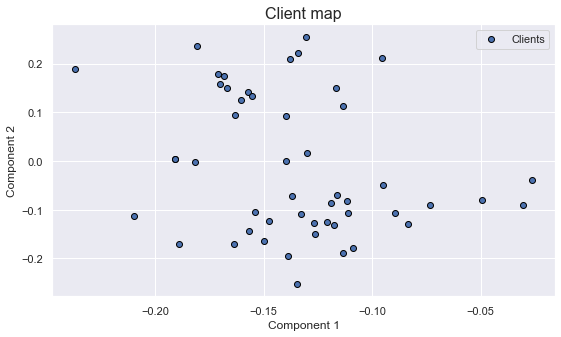

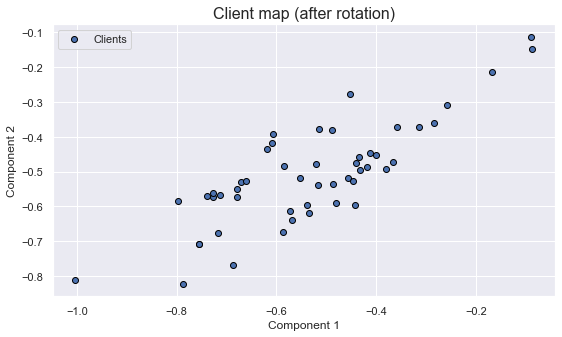

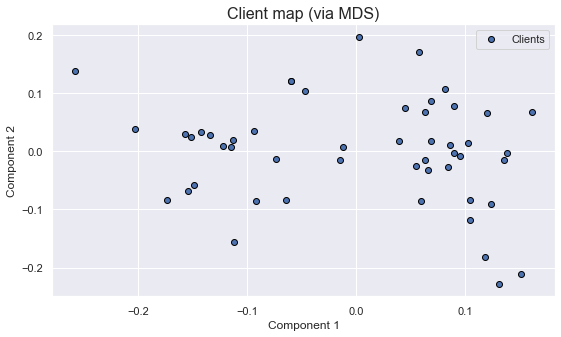

In [44]:
plt.figure(figsize=(9, 5))
plt.scatter(comp_K[:, 0], comp_K[:, 1], label='Clients', edgecolors='black')
plt.legend()
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title('Client map', fontsize=16)
plt.show()

plt.figure(figsize=(9, 5))
plt.scatter(comp_K_rotated[:, 0], comp_K_rotated[:, 1], label='Clients', edgecolors='black')
plt.legend()
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title('Client map (after rotation)', fontsize=16)
plt.show()

plt.figure(figsize=(9, 5))
plt.scatter(embeddings[:, 0], embeddings[:, 1], label='Clients', edgecolors='black')
plt.legend()
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title('Client map (via MDS)', fontsize=16)
plt.show()